Install Pacakge

In [1]:
!pip install -q transformers datasets z3-solver scikit-learn


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
from transformers import pipeline
from datasets import load_dataset
import random
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from z3 import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import ast


Load Text2Log dataset (1000 samples)

In [118]:
# Load Text2Log dataset (1000 samples)
dataset = load_dataset("alevkov95/text2log")
data = dataset["train"].select(range(1000))


In [4]:
from huggingface_hub import login
login()

Load LLaMA model

In [113]:
# Load LLaMA model
from transformers import AutoTokenizer
import torch
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")

pipe = pipeline(
    "text-generation",
    model="meta-llama/Llama-3.2-1B-Instruct",
    tokenizer=tokenizer,
    device_map="auto",
    pad_token_id=tokenizer.eos_token_id,
    torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32
)


## Prompt Engineering

instruction_prompt

In [111]:
instruction_prompt = """
You are a predicate logic assistant specializing in translating natural language into first-order logic (FOL).
Respond only with a valid FOL expression that is logically equivalent to the given sentence.
"""

Few_shot_prompt

In [115]:
def build_few_shot_prompt(input_sentence, examples):
    demo_str = "\n".join([f"Sentence: {ex['sentence']}\nFOL: {ex['fol_translation']}" for ex in examples])
    user_prompt = f"{demo_str}\n\nSentence: {input_sentence}\nFOL:"
    return user_prompt

## Evaluation Methods

Cosine_similarity and z3_similarity

In [97]:
def cosine_similarity_score(a, b):
    if isinstance(a, list): a = " ".join(map(str, a))
    if isinstance(b, list): b = " ".join(map(str, b))
    
    vec = TfidfVectorizer().fit_transform([a, b])
    return cosine_similarity(vec[0], vec[1])[0][0]
def text2log_to_z3(expr):
    expr = re.sub(r'\bexists\s+(x\d+)\.', r'Exists(\1,', expr)
    expr = re.sub(r'\bforall\s+(x\d+)\.', r'ForAll(\1,', expr)
    expr = re.sub(r'(?<![=!<>])=(?!=)', '==', expr)
    expr = expr.replace('&', ',').replace('|', ',')
    expr = re.sub(r'(?<=\w)\s+(?=\w)', '', expr)  
    if expr.count('(') > expr.count(')'):
        expr += ')' * (expr.count('(') - expr.count(')'))
    return expr

def same_predicate_set(f1, f2):
    preds1 = set(re.findall(r'\b_?[a-zA-Z_]+\b(?=\()', f1))
    preds2 = set(re.findall(r'\b_?[a-zA-Z_]+\b(?=\()', f2))
    return preds1 == preds2

def z3_equivalent(pred_formula, gold_formula):
    if not same_predicate_set(pred_formula, gold_formula):
        return False 
    try:
        pred_formula = text2log_to_z3(pred_formula)
        gold_formula = text2log_to_z3(gold_formula)
        # print(pred_formula,gold_formula)
        all_text = pred_formula + gold_formula
        var_names = sorted(set(re.findall(r'\bx\d+\b', all_text)))
        func_names = sorted(set(re.findall(r'\b_?[a-zA-Z_]+\b(?=\()', all_text)) - set(var_names))

        local_dict = {v: Const(v, IntSort()) for v in var_names}
        for f in func_names:
            local_dict[f] = Function(f, IntSort(), BoolSort())

        local_dict.update({"And": And, "Or": Or, "Not": Not, "Implies": Implies,
                           "Exists": Exists, "ForAll": ForAll})

        pred = eval(pred_formula, {}, local_dict)
        gold = eval(gold_formula, {}, local_dict)
        # print(pred,gold)
        s = Solver()
        s.add(Not(pred == gold))
        return s.check() == unsat
    except Exception as e:
        return False

In [109]:
# z3_equivalent(data_df["F_output"][2], data_df["gold_fol"][0])

Run model on data with different prompts

In [132]:
example=random.sample(list(data), 1)[0]
input_sentence = example['sentence']
target_fol = example['fol_translation']
input_sentence,target_fol

('Some reports were duplicates.',
 'exists x1.(_report(x1) & exists x2.(_duplicate(x2) & (x1 = x2)))')

Example for Instruction prompt

In [133]:
# Example for Instruction 
dummy_prompt = [[
    {"role": "system", "content": instruction_prompt},
    {
    "role": "user",
    "content": f'Translate this sentence into first-order logic:\n"{input_sentence}"'
    }
]]

pipe(dummy_prompt, max_new_tokens=64, do_sample=False)

/home/jingtao/.venv/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:590: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/jingtao/.venv/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:595: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


[[{'generated_text': [{'role': 'system',
     'content': '\nYou are a predicate logic assistant specializing in translating natural language into first-order logic (FOL).\nRespond only with a valid FOL expression that is logically equivalent to the given sentence.\n'},
    {'role': 'user',
     'content': 'Translate this sentence into first-order logic:\n"Some reports were duplicates."'},
    {'role': 'assistant',
     'content': 'The translation of the sentence "Some reports were duplicates" into first-order logic is:\n\n∃x (Report(x) ∧ Report(x) ∧ Report(x))'}]}]]

Example for Few_shot Prompt

In [ ]:
few_shot_example = random.sample(list(data), 5)
fewshot_user_prompt = build_few_shot_prompt(input_sentence, few_shot_example)

fewshot_prompt = [[
    {"role": "system", "content": instruction_prompt},
    {"role": "user", "content": fewshot_user_prompt}
]]
# 
pipe(fewshot_prompt, max_new_tokens=64, do_sample=False)


[[{'generated_text': [{'role': 'system',
     'content': '\nYou are a predicate logic assistant specializing in translating natural language into first-order logic (FOL).\nRespond only with a valid FOL expression that is logically equivalent to the given sentence.\n'},
    {'role': 'user',
     'content': 'Sentence: Some teachers were Americans.\nFOL: exists x1.(_teacher(x1) & exists x2.(_americans(x2) & (x1 = x2)))\nSentence: Some children are worriers.\nFOL: exists x1.(_child(x1) & exists x2.(_worrier(x2) & (x1 = x2)))\nSentence: Some folks are naysayers.\nFOL: exists x1.(_folk(x1) & exists x2.(_naysayer(x2) & (x1 = x2)))\nSentence: Some things are mistakes.\nFOL: exists x1.(_thing(x1) & exists x2.(_mistake(x2) & (x1 = x2)))\nSentence: Some people are asshats.\nFOL: exists x1.(_people(x1) & exists x2.(_asshat(x2) & (x1 = x2)))\n\nSentence: Some reports were duplicates.\nFOL:'},
    {'role': 'assistant',
     'content': 'Sentence: Some reports were duplicates.\nFOL: exists x1.(_report

In [29]:
def extract_generated_text(entry):
    if isinstance(entry, str):
        return entry
    elif isinstance(entry, dict) and 'generated_text' in entry:
        return entry['generated_text']
    elif isinstance(entry, list) and len(entry) > 0:
        return extract_generated_text(entry[0])  
    return ""


train code

In [30]:
results = []
few_shot_examples = random.sample(list(data), 5)
batch_size = 10


for i in tqdm(range(0, len(data), batch_size), desc="Processing batches"):
    batch = data.select(range(i, i+batch_size)).to_dict()
    sentences = batch['sentence']
    gold_fols = batch['fol_translation']

    prompts1 = [
        [
            {"role": "system", "content": instruction_prompt},
            {"role": "user", "content": f"Translate this sentence into first-order logic:\n\"{s}\""}
        ] for s in sentences
    ]

    prompts2 = [
        [
            {"role": "system", "content": instruction_prompt},
            {"role": "user", "content": build_few_shot_prompt(s, few_shot_examples)}
        ] for s in sentences
    ]
    
    print(f"Running batch {i}...")
    try:
        outputs1 = pipe(prompts1, max_new_tokens=128, do_sample=False)
        outputs2 = pipe(prompts2, max_new_tokens=128, do_sample=False)
    except Exception as e:
        outputs1 = outputs2 = [{"generated_text": f"Error: {e}"}] * len(batch)

    for j in range(len(batch)):
        out1 = extract_generated_text(outputs1[j])
        out2 = extract_generated_text(outputs2[j])
        cos_sim1 = cosine_similarity_score(out1, gold_fols[j])
        cos_sim2 = cosine_similarity_score(out2, gold_fols[j])
        z3_match1 = z3_equivalent(out1, gold_fols[j])
        z3_match2 = z3_equivalent(out2, gold_fols[j])

        results.append({
            "sentence": sentences[j],
            "gold_fol": gold_fols[j],
            "instruction_output": out1,
            "fewshot_output": out2,
            "cos_sim_instruction": cos_sim1,
            "cos_sim_fewshot": cos_sim2,
            "z3_instruction_match": z3_match1,
            "z3_fewshot_match": z3_match2
        })

Processing batches:   0%|          | 0/100 [00:00<?, ?it/s]

Running batch 0...


Processing batches:   1%|          | 1/100 [00:28<47:39, 28.89s/it]

Running batch 10...


Processing batches:   2%|▏         | 2/100 [01:08<57:17, 35.08s/it]

Running batch 20...


Processing batches:   3%|▎         | 3/100 [01:39<53:44, 33.24s/it]

Running batch 30...


Processing batches:   4%|▍         | 4/100 [02:13<53:47, 33.62s/it]

Running batch 40...


Processing batches:   5%|▌         | 5/100 [02:43<51:03, 32.25s/it]

Running batch 50...


Processing batches:   6%|▌         | 6/100 [03:19<52:25, 33.47s/it]

Running batch 60...


Processing batches:   7%|▋         | 7/100 [03:57<54:23, 35.10s/it]

Running batch 70...


Processing batches:   8%|▊         | 8/100 [04:30<52:43, 34.39s/it]

Running batch 80...


Processing batches:   9%|▉         | 9/100 [05:04<52:08, 34.38s/it]

Running batch 90...


Processing batches:  10%|█         | 10/100 [05:37<50:51, 33.90s/it]

Running batch 100...


Processing batches:  11%|█         | 11/100 [06:10<49:34, 33.42s/it]

Running batch 110...


Processing batches:  12%|█▏        | 12/100 [06:41<48:09, 32.83s/it]

Running batch 120...


Processing batches:  13%|█▎        | 13/100 [07:15<48:17, 33.31s/it]

Running batch 130...


Processing batches:  14%|█▍        | 14/100 [07:47<46:56, 32.75s/it]

Running batch 140...


Processing batches:  15%|█▌        | 15/100 [08:16<44:44, 31.59s/it]

Running batch 150...


Processing batches:  16%|█▌        | 16/100 [08:56<47:53, 34.21s/it]

Running batch 160...


Processing batches:  17%|█▋        | 17/100 [09:30<47:20, 34.22s/it]

Running batch 170...


Processing batches:  18%|█▊        | 18/100 [10:09<48:24, 35.42s/it]

Running batch 180...


Processing batches:  19%|█▉        | 19/100 [10:50<50:22, 37.32s/it]

Running batch 190...


Processing batches:  20%|██        | 20/100 [11:26<49:08, 36.86s/it]

Running batch 200...


Processing batches:  21%|██        | 21/100 [12:02<48:15, 36.65s/it]

Running batch 210...


Processing batches:  22%|██▏       | 22/100 [12:39<47:36, 36.62s/it]

Running batch 220...


Processing batches:  23%|██▎       | 23/100 [13:19<48:14, 37.59s/it]

Running batch 230...


Processing batches:  24%|██▍       | 24/100 [13:50<45:05, 35.59s/it]

Running batch 240...


Processing batches:  25%|██▌       | 25/100 [14:23<43:36, 34.89s/it]

Running batch 250...


Processing batches:  26%|██▌       | 26/100 [14:56<42:28, 34.44s/it]

Running batch 260...


Processing batches:  27%|██▋       | 27/100 [15:36<43:47, 36.00s/it]

Running batch 270...


Processing batches:  28%|██▊       | 28/100 [16:14<43:52, 36.56s/it]

Running batch 280...


Processing batches:  29%|██▉       | 29/100 [16:45<41:21, 34.94s/it]

Running batch 290...


Processing batches:  30%|███       | 30/100 [17:19<40:33, 34.76s/it]

Running batch 300...


Processing batches:  31%|███       | 31/100 [17:51<38:57, 33.88s/it]

Running batch 310...


Processing batches:  32%|███▏      | 32/100 [18:25<38:32, 34.01s/it]

Running batch 320...


Processing batches:  33%|███▎      | 33/100 [18:56<36:48, 32.96s/it]

Running batch 330...


Processing batches:  34%|███▍      | 34/100 [19:32<37:16, 33.88s/it]

Running batch 340...


Processing batches:  35%|███▌      | 35/100 [20:07<37:14, 34.38s/it]

Running batch 350...


Processing batches:  36%|███▌      | 36/100 [20:42<36:34, 34.29s/it]

Running batch 360...


Processing batches:  37%|███▋      | 37/100 [21:15<35:39, 33.95s/it]

Running batch 370...


Processing batches:  38%|███▊      | 38/100 [21:48<34:53, 33.77s/it]

Running batch 380...


Processing batches:  39%|███▉      | 39/100 [22:23<34:37, 34.06s/it]

Running batch 390...


Processing batches:  40%|████      | 40/100 [22:56<33:41, 33.69s/it]

Running batch 400...


Processing batches:  41%|████      | 41/100 [23:29<32:54, 33.46s/it]

Running batch 410...


Processing batches:  42%|████▏     | 42/100 [24:05<33:07, 34.27s/it]

Running batch 420...


Processing batches:  43%|████▎     | 43/100 [24:49<35:26, 37.30s/it]

Running batch 430...


Processing batches:  44%|████▍     | 44/100 [25:25<34:22, 36.82s/it]

Running batch 440...


Processing batches:  45%|████▌     | 45/100 [26:08<35:29, 38.72s/it]

Running batch 450...


Processing batches:  46%|████▌     | 46/100 [26:45<34:22, 38.19s/it]

Running batch 460...


Processing batches:  47%|████▋     | 47/100 [27:24<33:59, 38.48s/it]

Running batch 470...


Processing batches:  48%|████▊     | 48/100 [28:00<32:36, 37.62s/it]

Running batch 480...


Processing batches:  49%|████▉     | 49/100 [28:38<32:12, 37.89s/it]

Running batch 490...


Processing batches:  50%|█████     | 50/100 [29:08<29:39, 35.60s/it]

Running batch 500...


Processing batches:  51%|█████     | 51/100 [29:48<29:59, 36.72s/it]

Running batch 510...


Processing batches:  52%|█████▏    | 52/100 [30:32<31:04, 38.84s/it]

Running batch 520...


Processing batches:  53%|█████▎    | 53/100 [31:02<28:31, 36.42s/it]

Running batch 530...


Processing batches:  54%|█████▍    | 54/100 [31:41<28:31, 37.21s/it]

Running batch 540...


Processing batches:  55%|█████▌    | 55/100 [32:26<29:34, 39.43s/it]

Running batch 550...


Processing batches:  56%|█████▌    | 56/100 [32:54<26:30, 36.14s/it]

Running batch 560...


Processing batches:  57%|█████▋    | 57/100 [33:28<25:20, 35.35s/it]

Running batch 570...


Processing batches:  58%|█████▊    | 58/100 [34:00<24:04, 34.38s/it]

Running batch 580...


Processing batches:  59%|█████▉    | 59/100 [34:42<25:03, 36.67s/it]

Running batch 590...


Processing batches:  60%|██████    | 60/100 [35:20<24:37, 36.94s/it]

Running batch 600...


Processing batches:  61%|██████    | 61/100 [35:55<23:37, 36.34s/it]

Running batch 610...


Processing batches:  62%|██████▏   | 62/100 [36:35<23:47, 37.57s/it]

Running batch 620...


Processing batches:  63%|██████▎   | 63/100 [37:11<22:55, 37.17s/it]

Running batch 630...


Processing batches:  64%|██████▍   | 64/100 [37:51<22:43, 37.88s/it]

Running batch 640...


Processing batches:  65%|██████▌   | 65/100 [38:26<21:41, 37.18s/it]

Running batch 650...


Processing batches:  66%|██████▌   | 66/100 [38:59<20:13, 35.70s/it]

Running batch 660...


Processing batches:  67%|██████▋   | 67/100 [39:36<19:58, 36.32s/it]

Running batch 670...


Processing batches:  68%|██████▊   | 68/100 [40:10<19:00, 35.65s/it]

Running batch 680...


Processing batches:  69%|██████▉   | 69/100 [40:48<18:40, 36.16s/it]

Running batch 690...


Processing batches:  70%|███████   | 70/100 [41:28<18:44, 37.48s/it]

Running batch 700...


Processing batches:  71%|███████   | 71/100 [42:04<17:51, 36.95s/it]

Running batch 710...


Processing batches:  72%|███████▏  | 72/100 [42:38<16:47, 35.97s/it]

Running batch 720...


Processing batches:  73%|███████▎  | 73/100 [43:17<16:34, 36.82s/it]

Running batch 730...


Processing batches:  74%|███████▍  | 74/100 [44:02<17:07, 39.52s/it]

Running batch 740...


Processing batches:  75%|███████▌  | 75/100 [44:35<15:36, 37.46s/it]

Running batch 750...


Processing batches:  76%|███████▌  | 76/100 [45:19<15:43, 39.31s/it]

Running batch 760...


Processing batches:  77%|███████▋  | 77/100 [46:02<15:35, 40.66s/it]

Running batch 770...


Processing batches:  78%|███████▊  | 78/100 [46:35<13:58, 38.13s/it]

Running batch 780...


Processing batches:  79%|███████▉  | 79/100 [47:09<12:59, 37.11s/it]

Running batch 790...


Processing batches:  80%|████████  | 80/100 [47:48<12:32, 37.62s/it]

Running batch 800...


Processing batches:  81%|████████  | 81/100 [48:28<12:09, 38.40s/it]

Running batch 810...


Processing batches:  82%|████████▏ | 82/100 [48:58<10:44, 35.79s/it]

Running batch 820...


Processing batches:  83%|████████▎ | 83/100 [49:40<10:36, 37.46s/it]

Running batch 830...


Processing batches:  84%|████████▍ | 84/100 [50:17<10:01, 37.60s/it]

Running batch 840...


Processing batches:  85%|████████▌ | 85/100 [50:58<09:35, 38.35s/it]

Running batch 850...


Processing batches:  86%|████████▌ | 86/100 [51:42<09:20, 40.05s/it]

Running batch 860...


Processing batches:  87%|████████▋ | 87/100 [52:19<08:28, 39.12s/it]

Running batch 870...


Processing batches:  88%|████████▊ | 88/100 [52:48<07:13, 36.16s/it]

Running batch 880...


Processing batches:  89%|████████▉ | 89/100 [53:32<07:03, 38.52s/it]

Running batch 890...


Processing batches:  90%|█████████ | 90/100 [54:11<06:26, 38.67s/it]

Running batch 900...


Processing batches:  91%|█████████ | 91/100 [54:46<05:39, 37.69s/it]

Running batch 910...


Processing batches:  92%|█████████▏| 92/100 [55:20<04:52, 36.52s/it]

Running batch 920...


Processing batches:  93%|█████████▎| 93/100 [55:59<04:19, 37.13s/it]

Running batch 930...


Processing batches:  94%|█████████▍| 94/100 [56:37<03:44, 37.46s/it]

Running batch 940...


Processing batches:  95%|█████████▌| 95/100 [57:13<03:06, 37.20s/it]

Running batch 950...


Processing batches:  96%|█████████▌| 96/100 [57:58<02:38, 39.53s/it]

Running batch 960...


Processing batches:  97%|█████████▋| 97/100 [58:44<02:03, 41.25s/it]

Running batch 970...


Processing batches:  98%|█████████▊| 98/100 [59:20<01:19, 39.65s/it]

Running batch 980...


Processing batches:  99%|█████████▉| 99/100 [1:00:01<00:40, 40.27s/it]

Running batch 990...


Processing batches: 100%|██████████| 100/100 [1:00:36<00:00, 36.37s/it]


In [31]:
# Convert to DataFrame
df = pd.DataFrame(results)
df.to_csv("llm_text2log_outputs.csv", index=False)

### Evaluation

In [2]:
data_df=pd.read_csv("/home/jingtao/Course Code/llm_text2log_outputs.csv")

In [3]:
data_df.head()

,sentence,gold_fol,instruction_output,fewshot_output,cos_sim_instruction,cos_sim_fewshot,z3_instruction_match,z3_fewshot_match
0,Some engineers were astronauts.,exists x1.(_engineer(x1) & exists x2.(_astrona...,"[{'role': 'system', 'content': '\nYou are a pr...","[{'role': 'system', 'content': '\nYou are a pr...",0.000000,0.757567,False,False
1,Some items were facts.,exists x1.(_item(x1) & exists x2.(_fact(x2) & ...,"[{'role': 'system', 'content': '\nYou are a pr...","[{'role': 'system', 'content': '\nYou are a pr...",0.000000,0.757567,False,False
2,Some owners were gentlemen.,exists x1.(_owner(x1) & exists x2.(_gentleman(...,"[{'role': 'system', 'content': '\nYou are a pr...","[{'role': 'system', 'content': '\nYou are a pr...",0.028637,0.757567,False,False
3,Some people are fans.,exists x1.(_people(x1) & exists x2.(_fan(x2) &...,"[{'role': 'system', 'content': '\nYou are a pr...","[{'role': 'system', 'content': '\nYou are a pr...",0.000000,0.723777,False,False
4,Some members are centres.,exists x1.(_member(x1) & exists x2.(_centre(x2...,"[{'role': 'system', 'content': '\nYou are a pr...","[{'role': 'system', 'content': '\nYou are a pr...",0.000000,0.744157,False,False


In [ ]:

def extract_fol_from_assistant_block(raw_text):
    try:
        
        blocks = ast.literal_eval(raw_text)

        
        for block in blocks:
            if isinstance(block, dict) and block.get('role') == 'assistant':
                content = block.get('content', '')
                match = re.search(r'FOL:\s*(.+)', content)
                if match:
                    return match.group(1).strip()
                else:
                    return content.strip()  
    except Exception as e:
        return f"[parse error] {e}"
    
    
def extract_last_line_from_assistant(raw_text):
    try:
        blocks = ast.literal_eval(raw_text)
        for block in blocks:
            if isinstance(block, dict) and block.get("role") == "assistant":
                content = block.get("content", "")
                lines = [line.strip() for line in content.splitlines() if line.strip()]
                if lines:
                    return lines[-1]
                return content.strip()
    except Exception as e:
        return f"[parse error] {e}"

### Example

In [28]:
data_df["fewshot_output"].iloc[0]

"[{'role': 'system', 'content': '\\nYou are a predicate logic assistant specializing in translating natural language into first-order logic (FOL).\\nRespond only with a valid FOL expression that is logically equivalent to the given sentence.\\n'}, {'role': 'user', 'content': 'Sentence: Some sets are sets.\\nFOL: exists x1.(_set(x1) & exists x2.(_set(x2) & (x1 = x2)))\\nSentence: Some cats are animals.\\nFOL: exists x1.(_cat(x1) & exists x2.(_animal(x2) & (x1 = x2)))\\nSentence: Some bends are characters.\\nFOL: exists x1.(_bend(x1) & exists x2.(_character(x2) & (x1 = x2)))\\nSentence: Some materials are mixtures.\\nFOL: exists x1.(_material(x1) & exists x2.(_mixture(x2) & (x1 = x2)))\\nSentence: Some individuals are kids.\\nFOL: exists x1.(_individual(x1) & exists x2.(_kid(x2) & (x1 = x2)))\\n\\nSentence: Some engineers were astronauts.\\nFOL:'}, {'role': 'assistant', 'content': 'Sentence: Some engineers were astronauts.\\nFOL: exists x1.(_engineer(x1) & exists x2.(_astronaut(x2) & (x1

In [15]:
extract_fol_from_assistant_block(data_df["fewshot_output"].iloc[0])


'exists x1.(_engineer(x1) & exists x2.(_astronaut(x2) & (x1 = x2)))'

In [29]:
data_df["instruction_output"].iloc[0]

'[{\'role\': \'system\', \'content\': \'\\nYou are a predicate logic assistant specializing in translating natural language into first-order logic (FOL).\\nRespond only with a valid FOL expression that is logically equivalent to the given sentence.\\n\'}, {\'role\': \'user\', \'content\': \'Translate this sentence into first-order logic:\\n"Some engineers were astronauts."\'}, {\'role\': \'assistant\', \'content\': \'The translation of the sentence "Some engineers were astronauts" into first-order logic is:\\n\\n∃x (E(x) ∧ A(x))\'}]'

In [27]:
# extract_fol_from_assistant_block(data_df["instruction_output"].iloc[0])
extract_last_line_from_assistant(data_df["instruction_output"].iloc[0])

'∃x (E(x) ∧ A(x))'

In [31]:
# Extract final expressions
data_df["I_output"] = data_df["instruction_output"].apply(extract_last_line_from_assistant)
data_df["F_output"] = data_df["fewshot_output"].apply(extract_fol_from_assistant_block)


In [98]:
# Recalculate cosine similarities
data_df["cos_sim_instruction"] = data_df.apply(lambda row: cosine_similarity_score(row["I_output"], row["gold_fol"]), axis=1)
data_df["cos_sim_fewshot"] = data_df.apply(lambda row: cosine_similarity_score(row["F_output"], row["gold_fol"]), axis=1)
data_df["z3_instruction_match"] = data_df.apply(lambda row: z3_equivalent(row["I_output"], row["gold_fol"]), axis=1)
data_df["z3_fewshot_match"] = data_df.apply(lambda row: z3_equivalent(row["F_output"], row["gold_fol"]), axis=1)

In [50]:
data_df["F_output"][0],data_df["gold_fol"][0]

('exists x1.(_engineer(x1) & exists x2.(_astronaut(x2) & (x1 = x2)))',
 'exists x1.(_engineer(x1) & exists x2.(_astronaut(x2) & (x1 = x2)))')

In [100]:
data_df.head()

,sentence,gold_fol,instruction_output,fewshot_output,cos_sim_instruction,cos_sim_fewshot,z3_instruction_match,z3_fewshot_match,I_output,F_output
0,Some engineers were astronauts.,exists x1.(_engineer(x1) & exists x2.(_astrona...,"[{'role': 'system', 'content': '\nYou are a pr...","[{'role': 'system', 'content': '\nYou are a pr...",0.00000,1.000000,False,True,∃x (E(x) ∧ A(x)),exists x1.(_engineer(x1) & exists x2.(_astrona...
1,Some items were facts.,exists x1.(_item(x1) & exists x2.(_fact(x2) & ...,"[{'role': 'system', 'content': '\nYou are a pr...","[{'role': 'system', 'content': '\nYou are a pr...",0.00000,1.000000,False,True,∃x (F(x) ∧ W(x)),exists x1.(_item(x1) & exists x2.(_fact(x2) & ...
2,Some owners were gentlemen.,exists x1.(_owner(x1) & exists x2.(_gentleman(...,"[{'role': 'system', 'content': '\nYou are a pr...","[{'role': 'system', 'content': '\nYou are a pr...",0.05015,1.000000,False,True,This expression states that there exists at le...,exists x1.(_owner(x1) & exists x2.(_gentleman(...
3,Some people are fans.,exists x1.(_people(x1) & exists x2.(_fan(x2) &...,"[{'role': 'system', 'content': '\nYou are a pr...","[{'role': 'system', 'content': '\nYou are a pr...",0.00000,0.920909,False,False,∃x (F(x) ∧ P(x)),exists x1.(_person(x1) & exists x2.(_fan(x2) &...
4,Some members are centres.,exists x1.(_member(x1) & exists x2.(_centre(x2...,"[{'role': 'system', 'content': '\nYou are a pr...","[{'role': 'system', 'content': '\nYou are a pr...",0.00000,1.000000,False,True,∃x (M(x) ∧ C(x)),exists x1.(_member(x1) & exists x2.(_centre(x2...


In [101]:
data_df.to_csv("llm_text2log_outputs.csv", index=False)

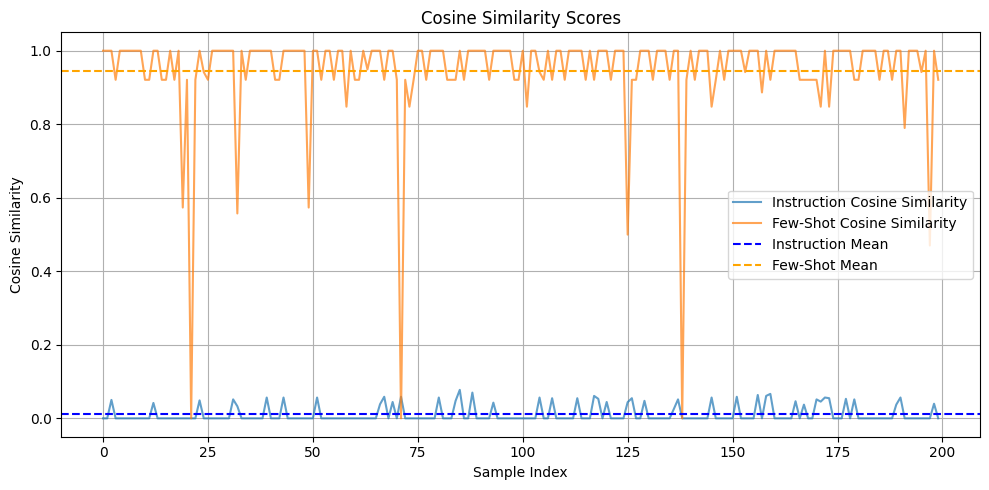

In [102]:
# Cosine Similarity Scores
cos_sim_instruction = data_df["cos_sim_instruction"]
cos_sim_fewshot = data_df["cos_sim_fewshot"]

# Plot cosine similarity scores as curves
plt.figure(figsize=(10, 5))
plt.plot(cos_sim_instruction, label="Instruction Cosine Similarity", alpha=0.7)
plt.plot(cos_sim_fewshot, label="Few-Shot Cosine Similarity", alpha=0.7)
plt.axhline(y=cos_sim_instruction.mean(), color='blue', linestyle='--', label='Instruction Mean')
plt.axhline(y=cos_sim_fewshot.mean(), color='orange', linestyle='--', label='Few-Shot Mean')
plt.title("Cosine Similarity Scores")
plt.xlabel("Sample Index")
plt.ylabel("Cosine Similarity")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Correct ratio under the instruction method: 0.0

 Correct ratio under the fewshot method: 0.605


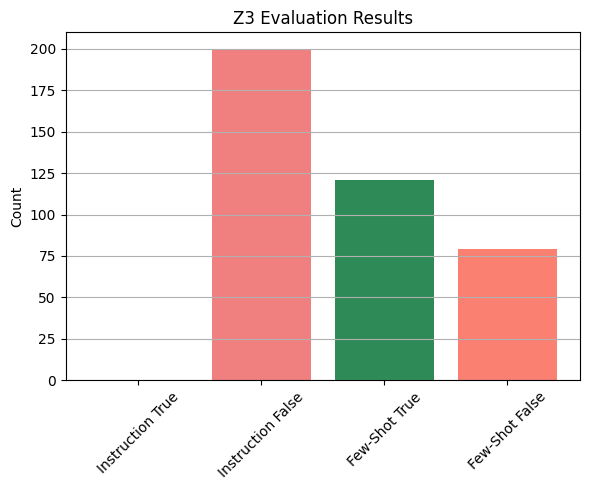

In [108]:
# Z3 True/False Frequency Bar Chart
z3_instruction = data_df["z3_instruction_match"]
z3_fewshot = data_df["z3_fewshot_match"]
# Compute Z3 match proportions
instruction_true = sum(data_df["z3_instruction_match"] == True)
instruction_total = data_df["z3_instruction_match"].notna().sum()
fewshot_true = sum(data_df["z3_fewshot_match"] == True)
fewshot_total = data_df["z3_fewshot_match"].notna().sum()

# Proportions
instruction_ratio = instruction_true / instruction_total
fewshot_ratio = fewshot_true / fewshot_total

print("Correct ratio under the instruction method:",instruction_ratio)
print("\n Correct ratio under the fewshot method:",fewshot_ratio)


plt.figure(figsize=(6, 5))
z3_counts = {
    "Instruction True": sum(z3_instruction == True),
    "Instruction False": sum(z3_instruction == False),
    "Few-Shot True": sum(z3_fewshot == True),
    "Few-Shot False": sum(z3_fewshot == False)
}
plt.bar(z3_counts.keys(), z3_counts.values(), color=['steelblue', 'lightcoral', 'seagreen', 'salmon'])
plt.title("Z3 Evaluation Results")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()